*Prepared for the course "TDPS22: Data Science Programming" at Jönköping University, Teacher: [Marcel Bollmann](mailto:marcel.bollmann@ju.se)*

# Exercise 8: Data wrangling with tidyr & dplyr

This notebook contains more exercises on data manipulation, this time focusing on tidying and joining data as described in [Chapter 12](https://r4ds.had.co.nz/tidy-data.html) and [Chapter 13](https://r4ds.had.co.nz/relational-data.html) of the book. We're using a lot of different datasets here to practice this in many different scenarios. We'll also briefly look at some functionality related to strings and factors.

### Learning Goals

- Understand _when a dataset is "tidy"_ and _how to bring a dataset into "tidy" format._
- Understand _how to use joins_ to combine and filter datasets.
- Have a basic understanding of _strings_ and _factors_ and how to manipulate them.

### Useful Resources

+ [§12 "Tidy data" in _R for Data Science_](https://r4ds.had.co.nz/tidy-data.html)
+ [§13 "Relational data" in _R for Data Science_](https://r4ds.had.co.nz/relational-data.html)
+ [§14 "Strings" in _R for Data Science_](https://r4ds.had.co.nz/strings.html)
+ [§15 "Factors" in _R for Data Science_](https://r4ds.had.co.nz/factors.html)
+ [RStudio Cheatsheets](https://www.rstudio.com/resources/cheatsheets/)

- - -


In [1]:
library(tidyverse)
library(lubridate)

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘hms’”
── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdi

- - -

### Datasets

We're using the Sweden vehicle registration dataset from Assignment 1; a dataset with Swedish population statistics; the coffee chain datasets that we saw before; and a modified sample of the Yu-Gi-Oh! dataset from Exercise 3. We'll try to reproduce some of the data wrangling that we've done before in Python.

In [2]:
vehicle <- read_csv("data/sweden-vehicle.csv")
population <- read_csv("data/sweden-population.csv", col_types="fDi")
coffee1 <- read_csv("data/coffee-chain.csv", col_types="cfffiii") %>% mutate(Ddate = mdy(Ddate))
coffee2 <- read_csv("data/coffee-chain-extra.csv", col_types="cffiii") %>% mutate(Ddate = mdy(Ddate))
yugioh <- read_csv("data/yu-gi-oh-messy.csv", col_types="ccccc")

Rows: 168 Columns: 197
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): region, fuel
dbl (195): 2006M01, 2006M02, 2006M03, 2006M04, 2006M05, 2006M06, 2006M07, 20...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


For the `vehicle` dataset, the inferred column types are `<chr>` (for strings) and `<dbl>` (for continuous numbers), but actually it would make more sense for them to be _factors_ and _integers_.  Here, you see a way to **mutate** these columns without listing all the numeric columns explicitly (as there are _a lot_ of them!):

In [3]:
vehicle <- mutate(
             vehicle,
             region = as.factor(region),
             fuel = as.factor(fuel),
             across(where(is.double), as.integer)
           )

head(vehicle)

region,fuel,2006M01,2006M02,2006M03,2006M04,2006M05,2006M06,2006M07,2006M08,⋯,2021M06,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03
<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Stockholm,petrol,2824,3431,4291,4872,5819,5648,3450,4087,⋯,3194,1607,1566,1511,1338,1316,1430,1226,1261,1702
Stockholm,diesel,884,895,1022,1059,1160,1059,783,1060,⋯,2151,713,975,1136,755,789,998,819,949,1121
Stockholm,electricity,1,0,0,0,0,0,0,0,⋯,3160,695,1331,2415,1576,1923,3306,1612,1879,3415
Stockholm,electric hybrid,101,87,131,102,95,118,72,108,⋯,946,452,446,420,408,435,506,471,523,653
Stockholm,plug-in hybrid,0,0,0,0,0,0,0,0,⋯,5204,1854,2070,1961,2084,2571,2988,2171,2372,2837
Stockholm,ethanol/ethanol flexifuel,620,752,1154,911,1004,817,564,514,⋯,33,44,43,33,37,22,40,22,62,58


- - - 

## Tidy data and pivoting

In Assignment 1, we converted the Sweden vehicle registration dataset into a form like this:

| **region** | **fuel**         | **date**    | **vehicles** |
|------------|------------------|-------------|--------------|
| Stockholm  | petrol           | 2006-01-01  | 2824         |
| Stockholm  | diesel           | 2006-01-01  | 884          |
| Stockholm  | electricity      | 2006-01-01  | 1            |
| ...        | ...              | ...         | ...          |

In the Tidyverse, this corresponds to a _tidy dataset_:

- each column corresponds to one _variable_ (region, fuel, date, number of registered vehicles);
- each row corresponds to one _observation_ (the number of registered vehicles of a certain type, at a specific region and date);
- each cell contains exactly one _value_.

_(Aside: You could argue that dates or date-times consist of *multiple* values: year, month, day, etc.; however, since these logically belong together and can be represented by & easily transformed as a single data type, it makes sense to treat them as "single" values.)_


**1. Transform the `vehicle` dataset into a tidy version!** It's easiest if you think about this in two steps:

- _pivoting_ the dataset into a _longer form_, i.e., converting the columns "2006M01", "2006M02", ... into a variable that has its own column;
- _transforming/mutating_ the new column to parse the string into an actual _date_ object.

In [4]:
vehicle_tidy <- vehicle %>%
  pivot_longer(
      contains("M"),           # many alternatives here, e.g.: starts_with("20"), -(region:fuel)
      names_to = "date",
      values_to = "vehicles"
  ) %>%
  mutate(date = ym(date))

head(vehicle_tidy)

region,fuel,date,vehicles
<fct>,<fct>,<date>,<int>
Stockholm,petrol,2006-01-01,2824
Stockholm,petrol,2006-02-01,3431
Stockholm,petrol,2006-03-01,4291
Stockholm,petrol,2006-04-01,4872
Stockholm,petrol,2006-05-01,5819
Stockholm,petrol,2006-06-01,5648


In [5]:
# ALTERNATIVELY, instead of piping into mutate(), we can also transform the column directly as an argument to pivot_longer():
vehicle_tidy <- vehicle %>%
  pivot_longer(
      -(region:fuel),
      names_to = "date",
      values_to = "vehicles",
      names_transform = list(date = ym)
  )

head(vehicle_tidy)

region,fuel,date,vehicles
<fct>,<fct>,<date>,<int>
Stockholm,petrol,2006-01-01,2824
Stockholm,petrol,2006-02-01,3431
Stockholm,petrol,2006-03-01,4291
Stockholm,petrol,2006-04-01,4872
Stockholm,petrol,2006-05-01,5819
Stockholm,petrol,2006-06-01,5648


Next, let's look at a small subset of the Yu-Gi-Oh! dataset which I transformed a little bit to make it "messy":

In [6]:
head(yugioh)

Name,Attributes,Sub-Types,Stat,Value
<chr>,<chr>,<chr>,<chr>,<chr>
Ancient Tool,Dark,Machine,Level,5
NA,NA,NA,ATK/DEF,1700/1400
Armored Starfish,Water,Aqua,Level,4
NA,NA,NA,ATK/DEF,850/1400
Giant Turtle Who Feeds on Flames,Water,Aqua,Level,5
NA,NA,NA,ATK/DEF,1400/1800


**2. Tidy up this messy `yugioh` dataset!** As it stands, the dataset has multiple features that make it "messy" or "untidy", and which you should address:

- Some variables (level, ATK or _attack points_, DEF or _defense points_) are spread across multiple rows
- Name, attributes, and sub-types of a card are not repeated on subsequent rows
- ATK and DEF are represented in a single cell

_Bonus:_ Also convert the columns of the tidied dataset to appropriate types!

In [7]:
yugioh %>%
  fill(Name, Attributes, `Sub-Types`) %>%
  pivot_wider(
      names_from = Stat,
      values_from = Value
  ) %>%
  separate(
      `ATK/DEF`,
      into = c("ATK", "DEF")   # could also write "Attack_Points" and "Defense_Points"
  ) %>%
  mutate(
      Attributes = as.factor(Attributes),  # maybe Sub-Types should be a factor as well, but I'm not sure, so I leave it
      Level = as.integer(Level),
      ATK = as.integer(ATK),
      DEF = as.integer(DEF)
  )

Name,Attributes,Sub-Types,Level,ATK,DEF
<chr>,<fct>,<chr>,<int>,<int>,<int>
Ancient Tool,Dark,Machine,5,1700,1400
Armored Starfish,Water,Aqua,4,850,1400
Giant Turtle Who Feeds on Flames,Water,Aqua,5,1400,1800
Giganto,Dark,Machine,5,1700,1800
Monster Egg,Earth,Warrior,3,600,900
Ocubeam,Light,Fairy,5,1550,1650
Petit Dragon,Wind,Dragon,2,600,700
Spikebot,Dark,Machine,5,1800,1700
Sectarian of Secrets,Dark,Spellcaster,2,700,500


**3. Tidy up the "pregnancy" data below!** This exercise is taken from the book. It defines a simple contingency table showing counts of male and female persons and whether they are pregnant or not. Think about the principles of tidy data – i.e., what are the variables, observations, values? – and bring the dataset into a tidy form.

In [8]:
(preg <- tribble(
  ~pregnant, ~male, ~female,
  "yes",     NA,    10,
  "no",      20,    12
))

pregnant,male,female
<chr>,<dbl>,<dbl>
yes,NA,10
no,20,12


In [9]:
preg %>%
  pivot_longer(
      -pregnant,
      names_to = "sex",
      values_to = "count",
      values_drop_na = TRUE   # can also keep this FALSE
  )

pregnant,sex,count
<chr>,<chr>,<dbl>
yes,female,10
no,male,20
no,female,12


In [10]:
# Note: Converting the count-based data to one-row-per-case (i.e., person)
# isn't strictly necessary to obtain a "tidy" dataset, but if you still
# want to do that, here's a way:
pregcases <- preg %>%
  pivot_longer(
      -pregnant,
      names_to = "sex",
      values_to = "count",
      values_drop_na = TRUE   # can also keep this FALSE
  )

idx <- rep.int(seq_len(nrow(pregcases)), pregcases$count)
pregcases[idx, ] %>% mutate(id = row_number()) %>% select(id, sex, pregnant)

# I didn't come up with this myself; I used the R Cookbook :)
# http://www.cookbook-r.com/Manipulating_data/Converting_between_data_frames_and_contingency_tables/#countstocases-function

id,sex,pregnant
<int>,<chr>,<chr>
1,female,yes
2,female,yes
3,female,yes
4,female,yes
5,female,yes
6,female,yes
7,female,yes
8,female,yes
9,female,yes


Finally, we'll turn to the Coffee Chain dataset again. In Exercise 1, Q8, we used a "pivot table" in Pandas to answer the question "How many instances are there in the dataset of each product–market combination?"  How can we produce a similar-looking table in R?

**4. Produce a "pivot table" from `coffee1` that shows the number of instances for each product–market combination!** The challenge here is that "pivot tables" in Pandas automatically perform some aggregation (e.g., counting the instances) for us, whereas `pivot_longer()` and `pivot_wider()` in `tidyr` _do not do that._ You therefore need to combine pivoting with computing the appropriate aggregation yourself (with functions we practised in Exercise 7).

As a reminder, in the end you should ideally have a table that looks something like this:

| Product            | Central | East | West | South |
|--------------------|---------|------|------|-------|
| Decaf Irish Cream  | 1189    | 560  | 789  | 578   |
| Decaf Espresso     | 227     | 328  | 460  | 134   |
| Caffe Latte        | 0       | 0    | 148  | 144   |
| ...                | ...     | ...  | ...  | ...   |


In [11]:
coffee1 %>%
  group_by(Product, Market) %>%
  summarise(Count = n()) %>%
  complete(Market, fill=list(Count = 0)) %>%
  pivot_wider(id_cols = Product, names_from = Market, values_from = Count)

`summarise()` has grouped output by 'Product'. You can override using the `.groups` argument.


Product,Central,East,West,South
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Decaf Irish Cream,1189,560,789,578
Decaf Espresso,227,328,460,134
Caffe Latte,0,0,148,144
Earl Grey,27,7,45,0
Amaretto,81,39,46,0
Lemon,309,305,290,239
Caffe Mocha,211,128,255,325
Mint,104,123,127,0
Darjeeling,426,582,618,0


- - - 

## Relational data, _aka_ combining datasets

In Exercise 1, we worked with the Coffee Chain dataset, and (among other things) practiced dataset combination with it. Let's try to recreate some of the things we did there in R.

First, we'd like to **concatenate** the `coffee1` and `coffee2` data. Unfortunately, the book doesn't directly mention how to do this! While technically possible to do with joins in this case, they're not quite the right the tool for the job, as the semantics of joins is that you're merging two datasets based on some kind of "ID" column(s).  Here, it's much better to use `dplyr::bind_rows()`:

In [12]:
coffee <- bind_rows(coffee1, coffee2)
nrow(coffee)  # confirm we have 15,000 rows

[1] 15000

**5. Merge `coffee` with the `markets` variable defined below!**  The resulting dataset should look just like `coffee`, but have an extra column "Market Size" whose value depends on the "Market" value of the given row.

In [13]:
(markets <- tibble(
    Market = c("Central", "East", "West", "South"),
    `Market Size` = c("Major", "Major", "Major", "Minor"),
) %>% mutate_all(as.factor))

Market,Market Size
<fct>,<fct>
Central,Major
East,Major
West,Major
South,Minor


In [14]:
coffee <- left_join(coffee, markets, by = "Market")
head(coffee)

Ddate,Market,Product,Product Type,Sales,Profit,Expenses,Market Size
<date>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>
2013-09-01,Central,Decaf Irish Cream,Coffee,90,36,37,Major
2012-05-01,East,Decaf Espresso,Espresso,203,56,55,Major
2013-01-01,West,Caffe Latte,Espresso,524,136,93,Major
2012-08-01,West,Earl Grey,Tea,273,81,68,Major
2013-12-01,West,Amaretto,Coffee,201,-3,68,Major
2012-09-01,East,Lemon,Herbal Tea,171,26,73,Major


**6. Fill in missing data in the `Product Type` column.**  Remember that the "Product Type" column had missing values, which could be uniquely deduced from the "Product" (e.g., a "Darjeeling" product is always a "Tea"). We can solve this here the same way as in Python, by first producing a dataset with all unique `(Product, Product Type)` combinations, and then joining this with our main dataset.

Some notes:

- Think carefully about _which type of join_ is appropriate in this situation.
- Make sure the final `coffee` dataset only has a single "Product Type" column, not two different ones.

In [15]:
products <- select(coffee, starts_with("Product")) %>% drop_na %>% unique
coffee <- coffee %>%
  select(-`Product Type`) %>%          # drop the original "Product Type" column
  left_join(products, by = "Product")  # join it in again from `products`, based on the "Product" value
head(coffee)

Ddate,Market,Product,Sales,Profit,Expenses,Market Size,Product Type
<date>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
2013-09-01,Central,Decaf Irish Cream,90,36,37,Major,Coffee
2012-05-01,East,Decaf Espresso,203,56,55,Major,Espresso
2013-01-01,West,Caffe Latte,524,136,93,Major,Espresso
2012-08-01,West,Earl Grey,273,81,68,Major,Tea
2013-12-01,West,Amaretto,201,-3,68,Major,Coffee
2012-09-01,East,Lemon,171,26,73,Major,Herbal Tea


**7. Merge the tidy `vehicle` dataset with the `population` dataset!** The `vehicle` dataset contains vehicle registration per region and date, while the `population` dataset contains population statistics per region and date. Join these two dataset in an appropriate way.

You will notice that the `population` dataset doesn't contain values for the entire date range in the `vehicle` dataset. Which type of join do you have to use when...

- you want to keep _all_ observation in `vehicle`, and accept that sometimes the population count has missing values?
- you want to keep _only_ those observations where you also have population data?

In [16]:
# Joining while keeping all vehicle observations:
vehicle <- vehicle_tidy
left_join(vehicle, population, by = c("region", "date"))

region,fuel,date,vehicles,population
<fct>,<fct>,<date>,<int>,<int>
Stockholm,petrol,2006-01-01,2824,1892368
Stockholm,petrol,2006-02-01,3431,1895163
Stockholm,petrol,2006-03-01,4291,1897880
Stockholm,petrol,2006-04-01,4872,1899715
Stockholm,petrol,2006-05-01,5819,1901767
Stockholm,petrol,2006-06-01,5648,1904204
Stockholm,petrol,2006-07-01,3450,1907133
Stockholm,petrol,2006-08-01,4087,1910401
Stockholm,petrol,2006-09-01,4412,1912787


In [17]:
# Joining while only keeping data with population count:
right_join(vehicle, population, by = c("region", "date"))

# Because the vehicle dataset does not have any missing values, an inner join is equivalent here:
inner_join(vehicle, population, by = c("region", "date"))

region,fuel,date,vehicles,population
<fct>,<fct>,<date>,<int>,<int>
Stockholm,petrol,2006-01-01,2824,1892368
Stockholm,petrol,2006-02-01,3431,1895163
Stockholm,petrol,2006-03-01,4291,1897880
Stockholm,petrol,2006-04-01,4872,1899715
Stockholm,petrol,2006-05-01,5819,1901767
Stockholm,petrol,2006-06-01,5648,1904204
Stockholm,petrol,2006-07-01,3450,1907133
Stockholm,petrol,2006-08-01,4087,1910401
Stockholm,petrol,2006-09-01,4412,1912787


region,fuel,date,vehicles,population
<fct>,<fct>,<date>,<int>,<int>
Stockholm,petrol,2006-01-01,2824,1892368
Stockholm,petrol,2006-02-01,3431,1895163
Stockholm,petrol,2006-03-01,4291,1897880
Stockholm,petrol,2006-04-01,4872,1899715
Stockholm,petrol,2006-05-01,5819,1901767
Stockholm,petrol,2006-06-01,5648,1904204
Stockholm,petrol,2006-07-01,3450,1907133
Stockholm,petrol,2006-08-01,4087,1910401
Stockholm,petrol,2006-09-01,4412,1912787


**8. Use a _filtering join_ to get only those rows in `vehicle` for which we do _not_ have population data!**  Also get a vector of the missing dates.

In [18]:
(missing <- anti_join(vehicle, population, by = c("region", "date")))
unique(missing$date)

region,fuel,date,vehicles
<fct>,<fct>,<date>,<int>
Stockholm,petrol,2022-02-01,1261
Stockholm,petrol,2022-03-01,1702
Stockholm,diesel,2022-02-01,949
Stockholm,diesel,2022-03-01,1121
Stockholm,electricity,2022-02-01,1879
Stockholm,electricity,2022-03-01,3415
Stockholm,electric hybrid,2022-02-01,523
Stockholm,electric hybrid,2022-03-01,653
Stockholm,plug-in hybrid,2022-02-01,2372


[1] "2022-02-01" "2022-03-01"

- - - 

## Strings, factors, and advanced operations

The book has a [chapter on strings and string manipulation](https://r4ds.had.co.nz/strings.html), but we're not going into this here in detail; instead, we'll just look at an example of using functions to automatically convert strings to lower, upper, or title case, which can occasionally come in handy:

In [19]:
mystr <- "this Is a wEIRdly FORMATTED strING."
str_to_lower(mystr)
str_to_upper(mystr)
str_to_title(mystr)

[1] "this is a weirdly formatted string."

[1] "THIS IS A WEIRDLY FORMATTED STRING."

[1] "This Is A Weirdly Formatted String."

**9. In the `vehicle` dataset, convert the "fuel" column to have all values in title case!**

In [20]:
(vehicle <- mutate(vehicle, fuel = str_to_title(fuel)))

region,fuel,date,vehicles
<fct>,<chr>,<date>,<int>
Stockholm,Petrol,2006-01-01,2824
Stockholm,Petrol,2006-02-01,3431
Stockholm,Petrol,2006-03-01,4291
Stockholm,Petrol,2006-04-01,4872
Stockholm,Petrol,2006-05-01,5819
Stockholm,Petrol,2006-06-01,5648
Stockholm,Petrol,2006-07-01,3450
Stockholm,Petrol,2006-08-01,4087
Stockholm,Petrol,2006-09-01,4412


Another data type that we have used, but not really looked at more closely, is the **factor**. In the `vehicle` dataset, for example, the "region" column is encoded as a factor:

In [21]:
is.factor(vehicle$region)

[1] TRUE

**10. Make sure that "fuel" is also a factor, and get the possible _levels_ of the factors "region" and "fuel" with the `levels()` command!** If "fuel" is not currently a factor, why do you think that is? Convert it (back) into a factor if necessary!

In [22]:
is.factor(vehicle$fuel)  # oops

[1] FALSE

In [23]:
vehicle <- mutate(vehicle, fuel = as.factor(fuel))
is.factor(vehicle$fuel)
levels(vehicle$region)
levels(vehicle$fuel)

[1] TRUE

[1] "Blekinge"        "Dalarna"         "Gävleborg"       "Gotland"        
 [5] "Halland"         "Jämtland"        "Jönköping"       "Kalmar"         
 [9] "Kronoberg"       "Norrbotten"      "Örebro"          "Östergötland"   
[13] "Skåne"           "Södermanland"    "Stockholm"       "Uppsala"        
[17] "Värmland"        "Västerbotten"    "Västernorrland"  "Västmanland"    
[21] "Västra Götaland"

[1] "Diesel"                    "Electric Hybrid"          
[3] "Electricity"               "Ethanol/Ethanol Flexifuel"
[5] "Gas/Gas Flex"              "Other Fuels"              
[7] "Petrol"                    "Plug-In Hybrid"

**11. Re-order the "fuel" factor to be sorted by the number of total vehicle registrations (in the following plot)!** If we produce a simple plot of the number of vehicle registrations _per fuel type_, we can see that "fuel" is ordered alphabetically be default:

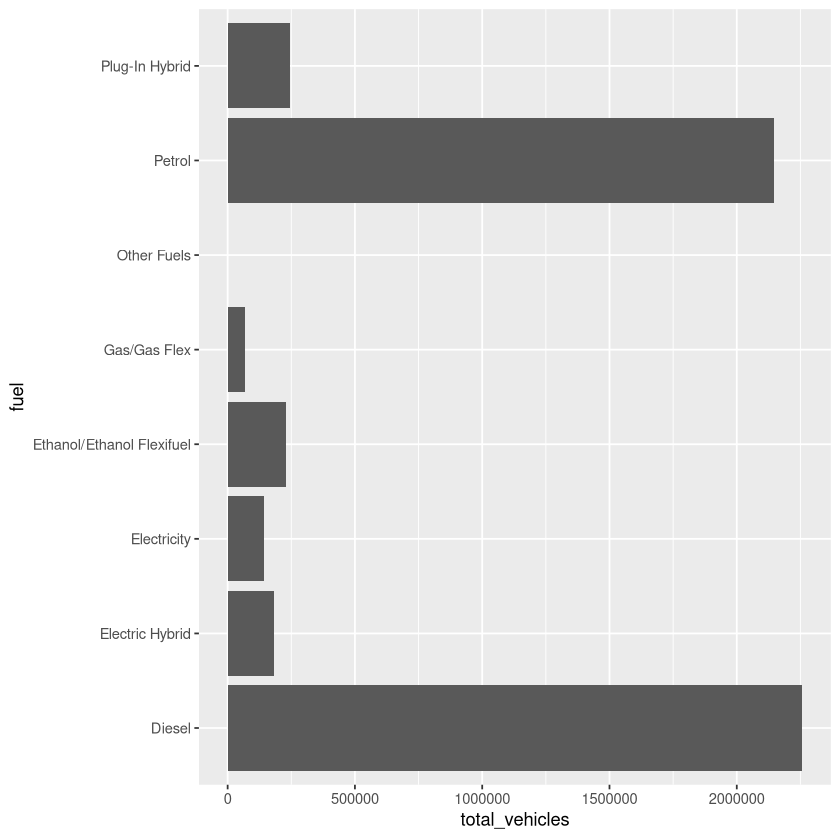

In [24]:
vehicle %>%
  group_by(fuel) %>%
  summarise(total_vehicles = sum(vehicles)) %>%
  ggplot(aes(total_vehicles, fuel)) +
    geom_col()

Change the plot by using `fct_reorder()` so that the different fuel types appear sorted (ascending or descending, your choice) by "total_vehicles"!

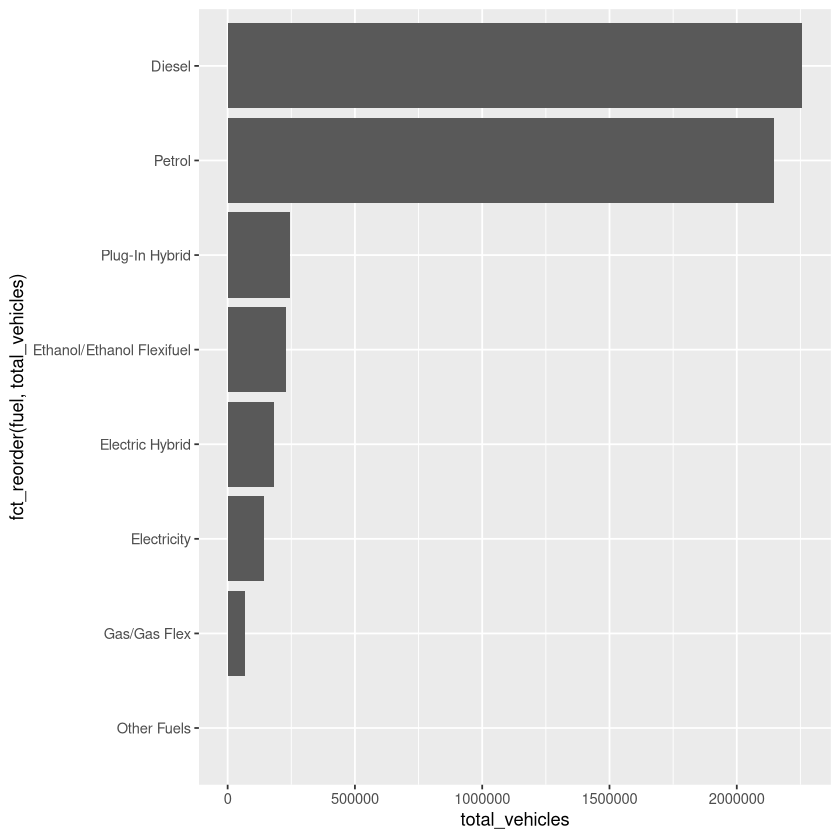

In [25]:
vehicle %>%
  group_by(fuel) %>%
  summarise(total_vehicles = sum(vehicles)) %>%
  ggplot(aes(total_vehicles, fct_reorder(fuel, total_vehicles))) +
    geom_col()

**12. Produce the same plot as in Q11, but with the "fuel" factor _re-coded_ as described in the table below!**

| Old value(s)                                  | New value    |
|-----------------------------------------------|--------------|
| Diesel                                        | Diesel       |
| Petrol                                        | Gasoline     |
| Electricity, Electric Hybrid, Plug-In Hybrid  | Electric     |
| Ethanol/Ethanol Flexifuel                     | Ethanol      |
| Gas/Gas Flex, Other Fuels                     | Other        |


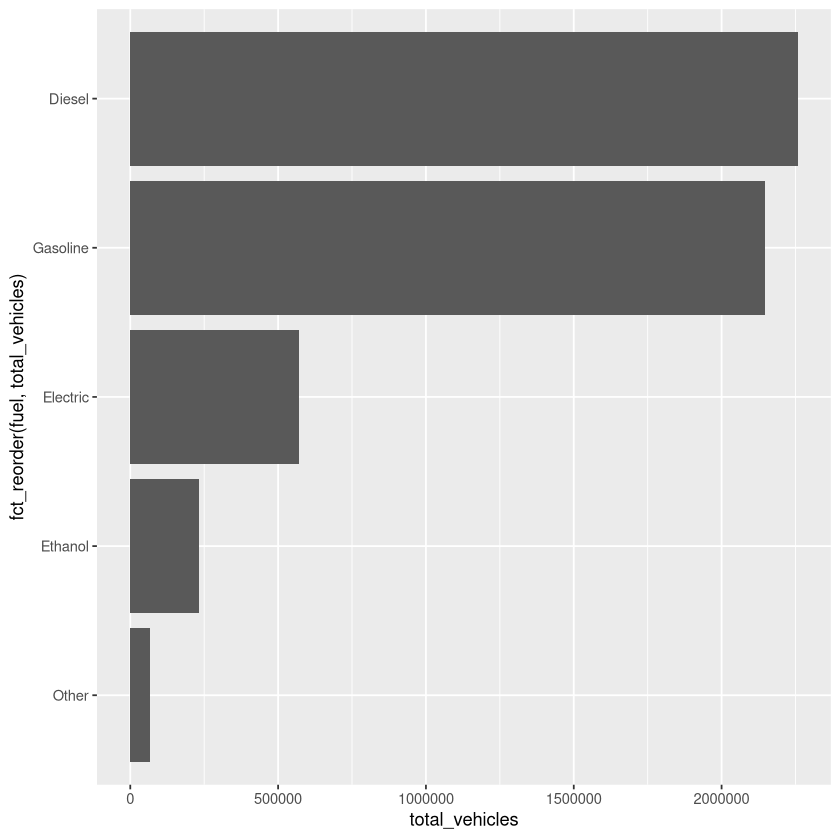

In [26]:
vehicle %>%
  # of course, using fct_collapse() is also a valid option here
  mutate(fuel = fct_recode(
      fuel,
      "Diesel" = "Diesel",
      "Gasoline" = "Petrol",
      "Electric" = "Electricity",
      "Electric" = "Electric Hybrid",
      "Electric" = "Plug-In Hybrid",
      "Ethanol" = "Ethanol/Ethanol Flexifuel",
      "Other" = "Gas/Gas Flex",
      "Other" = "Other Fuels"
  )) %>%
  group_by(fuel) %>%
  summarise(total_vehicles = sum(vehicles)) %>%
  ggplot(aes(total_vehicles, fct_reorder(fuel, total_vehicles))) +
    geom_col()

**13. Try to use `fct_lump()` to reduce the levels in the plot from Q11.** The book mentions `fct_lump()` as the solution when "you just want to lump together all the small groups to make a plot or table simpler". This sounds like we could use that to make our plot from Q11 simpler, right? Figure out what happens if you try to use `fct_lump()` in connection with the plot from Q11. If the results don't look like you expect, try to figure out why! This is a bit deceiving.

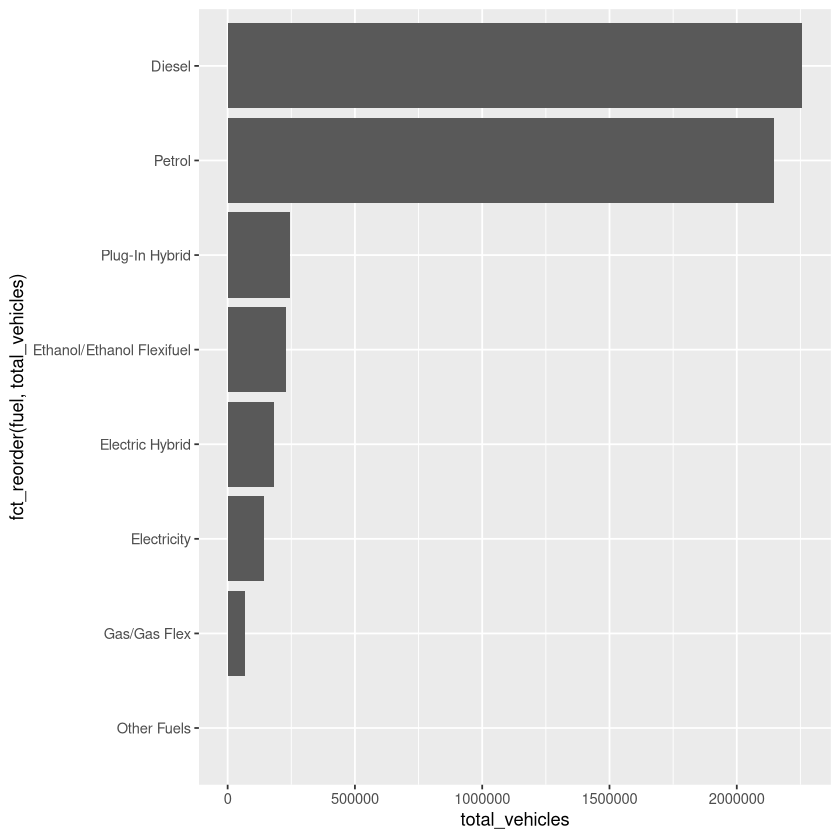

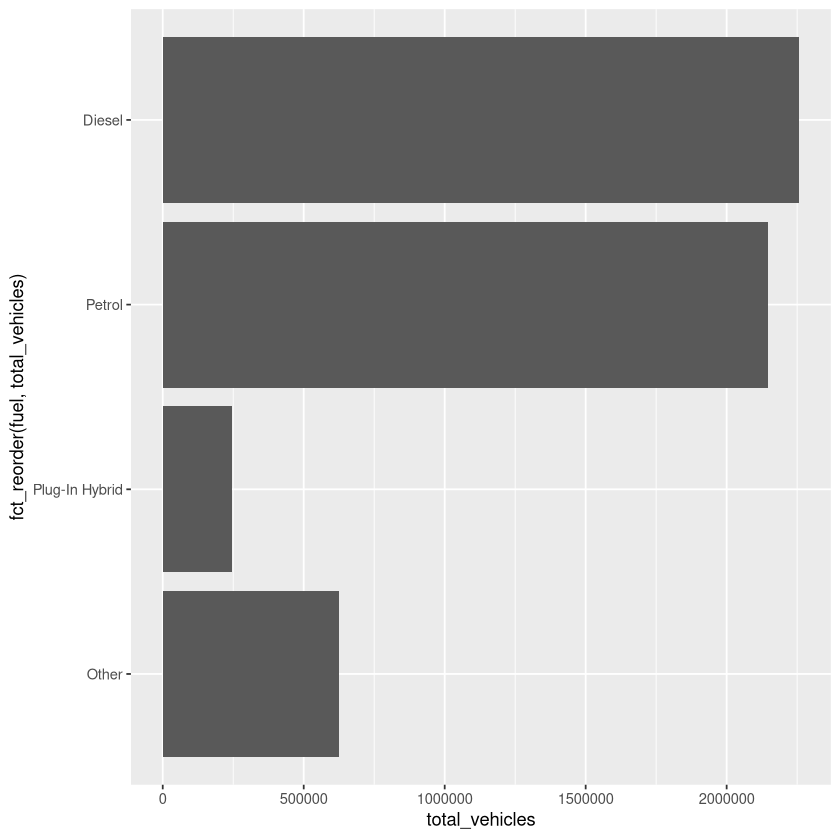

In [27]:
# This looks the same because fct_lump() cares about *how often* the levels
# appear in the data. However, each fuel type appears exactly the same number
# of types!
vehicle %>%
  mutate(fuel = fct_lump(fuel)) %>%
  group_by(fuel) %>%
  summarise(total_vehicles = sum(vehicles)) %>%
  ggplot(aes(total_vehicles, fct_reorder(fuel, total_vehicles))) +
    geom_col()

# Instead, we can use the "weight" factor to weight each level by the
# "total_vehicles" value, which is what we actually care about here.
vehicle %>%
  group_by(fuel) %>%
  summarise(total_vehicles = sum(vehicles)) %>%
  mutate(fuel = fct_lump(fuel, n = 3, w = total_vehicles)) %>%
  ggplot(aes(total_vehicles, fct_reorder(fuel, total_vehicles))) +
    geom_col()


**14. In the `coffee` dataset, make a new column "Top within Product" that is `True` when the "Profit" is within the top 25% of its "Product" category.**

Moving away from factors, this is a task we've seen in the Python exercises, and again, this can be quite challenging! However, it can be solved entirely with the functionality we have learned so far (even in a single pipeline, if you want!), with only one extra ingredient you might need: to get the cutoff for the "top 25%", look up the `quantile()` function.

In [28]:
(coffee <- coffee %>%
  group_by(Product) %>%
  summarise(cutoff = quantile(Profit)[["75%"]]) %>%
  right_join(coffee, by = "Product") %>%
  mutate(
      `Top within Product` = (Profit > cutoff)
  ) %>%
  select(
      Ddate, Product, `Product Type`,
      everything(),
      -cutoff
  ))

Ddate,Product,Product Type,Market,Sales,Profit,Expenses,Market Size,Top within Product
<date>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<lgl>
2013-09-01,Decaf Irish Cream,Coffee,Central,90,36,37,Major,FALSE
2013-02-01,Decaf Irish Cream,Coffee,Central,225,160,56,Major,TRUE
2013-09-01,Decaf Irish Cream,Coffee,Central,208,105,43,Major,TRUE
2012-01-01,Decaf Irish Cream,Coffee,Central,316,163,64,Major,TRUE
2012-01-01,Decaf Irish Cream,Coffee,South,112,66,24,Minor,FALSE
2013-02-01,Decaf Irish Cream,Coffee,South,130,68,43,Minor,FALSE
2012-01-01,Decaf Irish Cream,Coffee,East,252,87,81,Major,FALSE
2013-07-01,Decaf Irish Cream,Coffee,Central,70,24,22,Major,FALSE
2013-02-01,Decaf Irish Cream,Coffee,South,96,27,39,Minor,FALSE


If you have added the column correctly, the following line should return "3725":

In [29]:
summarise(coffee, x = sum(`Top within Product`))$x

[1] 3725